## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done.
Clustering can help discover valuable, hidden groupings within the data. The
dataset is created in the [obtain_dataset Notebook](obtain_dataset.ipynb).


In [43]:
# imports
import numpy as np
import pandas as pd
from ast import literal_eval

# load data
datafile_path = "./data/english_free_text_with_embeddings_1k.csv"

df = pd.read_csv(datafile_path)

question = "whyProblemSoc"

# convert string to numpy array
df[question + '-embedding'] = df[question + '-embedding'].apply(literal_eval).apply(np.array)

# take only answers with more than 100 characters
df = df[df[question].str.len() > 20]

matrix = np.vstack(df[question + '-embedding'].values)
matrix.shape


(119, 1536)

### 1. Find the clusters using K-means


We show the simplest use of K-means. You can pick the number of clusters that
fits your use case best.


In [44]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

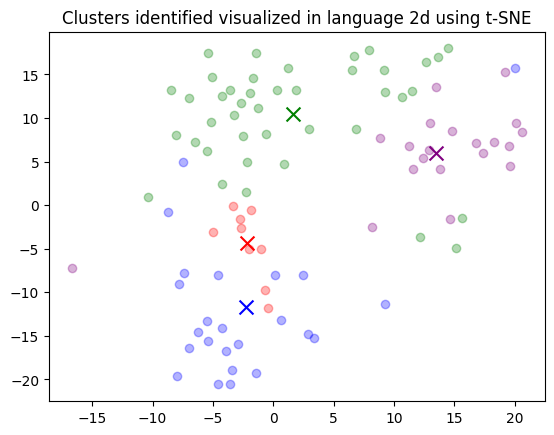

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. Let's see a few samples from each
cluster.


### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use text-davinci-003 to name
the clusters, based on a random sample of 5 reviews from that cluster.


In [47]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .loc[:, question]
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'Here are some answers to the question "For what reasons do you think food loss and waste is a problem?"\n\nAnswers:\n"""\n{reviews}\n"""\n\nWhat is the common theme in these answers?\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(f"\t{j+1}. {sample_cluster_rows.iloc[j][question]}")

    print("-" * 100)


Cluster 0 Theme:  Excess food being wasted or not being used.
	1. Bcoz people order to much then they can't finish
	2. Too much food cooked for very less food
	3. over buying in surplus quantity
	4. over or more than enough cooked food
	5. Poepl Don't eat leftovers they order again and food is wasted
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  The consequences of food loss and waste on people who lack access to food.
	1. well lot of people all over the wold have food crisis
	2. Because a lot of people don’t have enough savings to purchase what other people wasting
	3. Because usually people buy too much
	4. Because we can find food anywhere and with a small budget, we are able to eat more depending on the food that we eat
	5. Its cause tnhe poverty
----------------------------------------------------------------------------------------------------
Cluster 2 Theme:  The negative impacts of food loss and waste on 

It's important to note that clusters will not necessarily match what you intend
to use them for. A larger amount of clusters will focus on more specific
patterns, whereas a small number of clusters will usually focus on largest
discrepencies in the data.
